#### Case 1: Isobaric evaporation of liquid hydrogen in a 4.89 $m^3$ spherical tank experiments.

This notebook sets up the isobaric evaporation of liquid hydrogen ($LH_2$) in a 4.89 $m^3$ storage tank. A high liquid filling, high heat ingress scenario from Hasan (1991) is considered. This tank is representative of lab-scale tanks used for cryogen evaporation experiments that measure boil-off rates and thermal stratification.

In [1]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

from scipy.integrate import simps

#### Setup tank and cryogen properties

In [2]:
# LNG tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 2.106 # Internal diameter / m
d_o = 2.106+2.08e-3   # External diameter / m
T_air = 350 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 0.01063 # W/m2/K
#U_V = 0.01063 # W/m2/K
U_V = 1e-8 # W/m2/K


# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 0 # W, 

# Spherical tank volume
V_tank = 4.89 #m^3

# Initial liquid filling / Dimensionless
LF = 0.95

# Specify tank operating pressure
P = 117e3 # Pa

Geo_v1 = "spherical"

Geo_l1 = "spherical"

# Initialize large-scale tank
small_tank1 = Tank(d_i, d_o, V_tank, Geo_v1, Geo_l1,LF)
small_tank1.set_HeatTransProps(U_L, U_V, T_air, Q_roof, Q_b, eta_w = 0.95)

# Initialise cryogen
hydrogen1 = Cryogen(name = "hydrogen")
hydrogen1.set_coolprops(P)


# Set cryogen
small_tank1.cryogen = hydrogen1

# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen1.name + " is %.1e kg/h" % (small_tank1.b_l_dot * 3600))

The initial evaporation rate of hydrogen is 3.4e-01 kg/h


Calculate initial evaporation rate and transient period

In [3]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen1.name + " is %.1e kg/h" % (small_tank1.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % small_tank1.tau)

# Minimum number of hours to achieve steady state 
tau_h1 = (np.floor(small_tank1.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h1 )

# Calculate boil-off rate
BOR1 = (small_tank1.b_l_dot * 24 * 3600) / (small_tank1.V * small_tank1.LF * small_tank1.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR1 * 100))

The initial evaporation rate of hydrogen is 3.4e-01 kg/h
Transient period = 7477.076 s 
Simulation time: 3 h
BOR = 2.503 %


#### Simulation setup and execution

In [4]:
# Define vertical spacing
dz = 0.01

# Calculate number of nodes
n_z = 1 + int(np.round(small_tank1.l_V/dz, 0))

# Define dimensionless computational grid
small_tank1.z_grid = np.linspace(0, 1, n_z)

# Insulated roof
small_tank1.U_roof = 0

# Define evaporation time as twice as the transient period
evap_time = 3600 *tau_h1*2
#evap_time = 3600*40

# Time step to record data, relevant for plotting integrated quantities
# such as the vapour to liquid heat transfer rate, Q_VL
small_tank1.time_interval = 60

# Time step to plot each vapour temperature profile
small_tank1.plot_interval = evap_time/6

# Simulate the evaporation
small_tank1.evaporate(evap_time)

c:\CryoEvap\notebooks\..\cryoevap\storage_tanks\tank.py:472: RuntimeWarning: divide by zero encountered in true_divide
  vz = self.v_z*(l_L[i]/zed)*(2*self.d_i/2 - l_L[i])/(2*self.d_i/2 - zed)


#### Visualisation of results

#### Vapour temperature

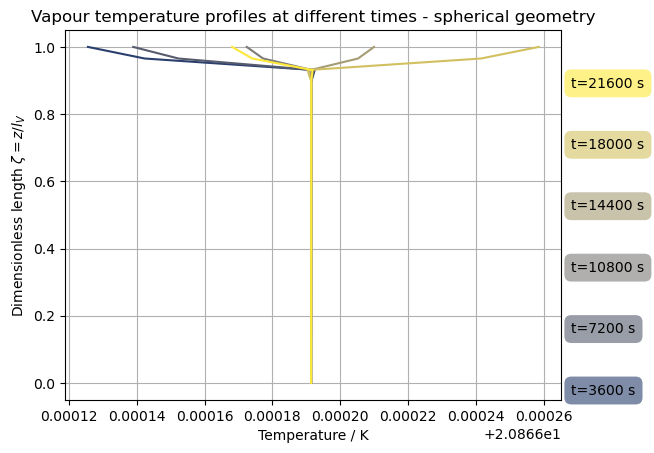

In [5]:
# Visualise the plot
small_tank1.plot_tv()

In [6]:
# small_tank1.plot_A_T()
# small_tank1.plot_l_L()
# small_tank1.plot_LF()
# small_tank1.plot_rho_V_avg()

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

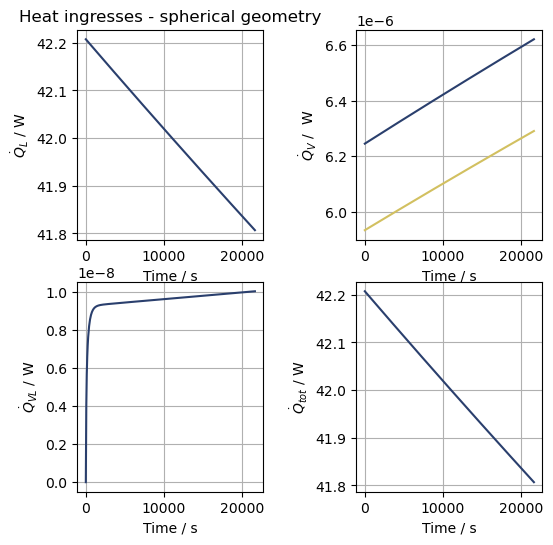

In [7]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank1.plot_Q(unit="W")

#### Plot liquid volume

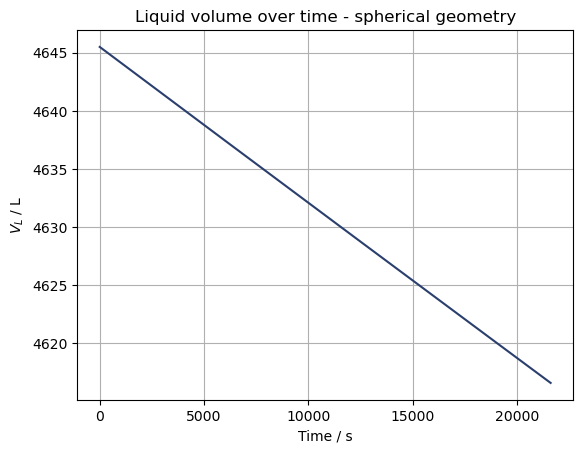

In [8]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank1.plot_V_L(unit="L")

In [9]:
small_tank1.z

1.8032438431618714

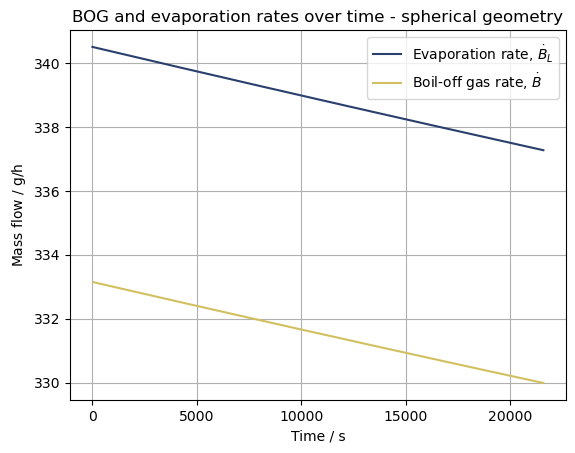

In [10]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank1.plot_BOG(unit='g/h')

c:\CryoEvap\notebooks\..\cryoevap\storage_tanks\plots.py:258: RuntimeWarning: divide by zero encountered in true_divide
  v_z = tank.v_z*(height/zed)*(2*tank.d_i/2 - height)/(2*tank.d_i/2 - zed)


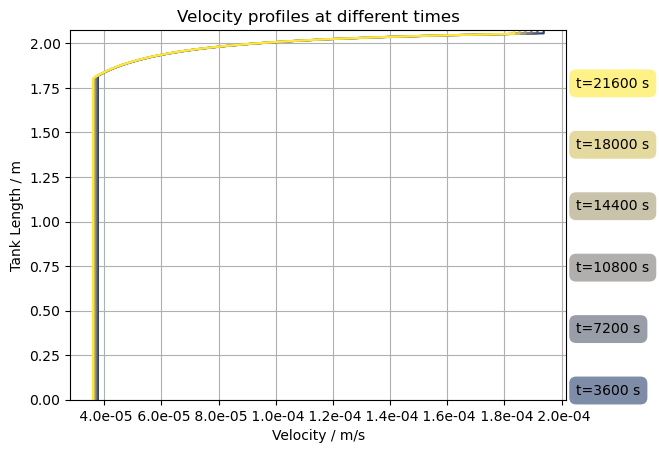

In [11]:
small_tank1.plot_vz()

In [12]:
print(len(small_tank1.data["BOG"]))

361


In [13]:
small_tank1.data["Pressure"] = np.ones_like(small_tank1.data["B_L"])*P
air = P*(V_tank*(1-LF))/(8.314*hydrogen1.T_sat)
for i in range(1,len(small_tank1.data["B_L"])):
    small_tank1.data["Pressure"][i] = ((simps(small_tank1.data["B_L"][:i])*(1000/2) +air)*8.314*small_tank1.data["Tv_avg"][i])/(V_tank - small_tank1.data["V_L"][i])

Optional: CSV data export

If evaporation data is intended to be post-processed in another software, it can be exported readily with the help of the Pandas package.

In [14]:
# Import pandas 
import pandas as pd

In [15]:
# Create dataframe from dictionary
df_evap = pd.DataFrame.from_dict(small_tank1.data)

# Save file to the current working directory
df_evap.to_csv('LN2_small_m3.csv')

# Show the first five columns of the dataframe in console
df_evap[-5:]

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,z,A_T,vz_avg,vz,LF,dTV_avg,Q_Vw,Pressure
356,21360.0,20.866191,1.517291,1.001790e-08,41.811187,0.000007,4.616887,0.000094,0.000092,7.721208e-10,-0.000001,1.803430,1.714251,0.00006,0.000036,0.944149,-7.978854e-09,0.000006,115355.957764
357,21420.0,20.866191,1.517291,1.001999e-08,41.810106,0.000007,4.616807,0.000094,0.000092,3.121217e-10,-0.000001,1.803384,1.714471,0.00006,0.000036,0.944132,-3.224195e-09,0.000006,115351.926141
358,21480.0,20.866191,1.517291,1.002210e-08,41.809025,0.000007,4.616727,0.000094,0.000092,7.462059e-10,-0.000001,1.803337,1.714691,0.00006,0.000036,0.944116,-7.710917e-09,0.000006,115347.898557
359,21540.0,20.866190,1.517291,1.002419e-08,41.807944,0.000007,4.616647,0.000094,0.000092,-8.156075e-11,-0.000001,1.803290,1.714911,0.00006,0.000036,0.944100,8.449749e-10,0.000006,115343.868883
360,21600.0,20.866191,1.517291,1.002630e-08,41.806863,0.000007,4.616567,0.000094,0.000092,-3.064922e-09,-0.000001,1.803244,1.715131,0.00006,0.000036,0.944083,3.168133e-08,0.000006,115339.851895


In [16]:
df_evap['flux_v'] = df_evap["Q_V"]/(np.pi*d_i*(d_i-df_evap['z']))
df_evap['flux_l'] = df_evap["Q_L"]/(np.pi*d_i*(df_evap['z']))
df_evap['total_flux'] = (df_evap['Q_L']+df_evap['Q_V'])/(np.pi*d_i**2)
df_evap.head()
df_evap[-5:]

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,...,A_T,vz_avg,vz,LF,dTV_avg,Q_Vw,Pressure,flux_v,flux_l,total_flux
356,21360.0,20.866191,1.517291,1.001790e-08,41.811187,0.000007,4.616887,0.000094,0.000092,7.721208e-10,...,1.714251,0.00006,0.000036,0.944149,-7.978854e-09,0.000006,115355.957764,0.000003,3.504167,3.000723
357,21420.0,20.866191,1.517291,1.001999e-08,41.810106,0.000007,4.616807,0.000094,0.000092,3.121217e-10,...,1.714471,0.00006,0.000036,0.944132,-3.224195e-09,0.000006,115351.926141,0.000003,3.504168,3.000646
358,21480.0,20.866191,1.517291,1.002210e-08,41.809025,0.000007,4.616727,0.000094,0.000092,7.462059e-10,...,1.714691,0.00006,0.000036,0.944116,-7.710917e-09,0.000006,115347.898557,0.000003,3.504168,3.000568
359,21540.0,20.866190,1.517291,1.002419e-08,41.807944,0.000007,4.616647,0.000094,0.000092,-8.156075e-11,...,1.714911,0.00006,0.000036,0.944100,8.449749e-10,0.000006,115343.868883,0.000003,3.504168,3.000491
360,21600.0,20.866191,1.517291,1.002630e-08,41.806863,0.000007,4.616567,0.000094,0.000092,-3.064922e-09,...,1.715131,0.00006,0.000036,0.944083,3.168133e-08,0.000006,115339.851895,0.000003,3.504168,3.000413


In [17]:
df_evap.head()

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,...,A_T,vz_avg,vz,LF,dTV_avg,Q_Vw,Pressure,flux_v,flux_l,total_flux
0,0.0,20.866191,1.517291,0.000000e+00,42.207326,0.000006,4.645500,0.000095,0.000095,0.000000e+00,...,1.632722,0.000064,0.000038,0.950000,0.000000e+00,0.000006,117000.000000,0.000003,3.504149,3.029154
1,60.0,20.866191,1.517291,4.022394e-09,42.206181,0.000006,4.645419,0.000095,0.000093,-9.926238e-12,...,1.632960,0.000064,0.000038,0.949983,-3.695637e-09,0.000006,116961.366310,0.000003,3.504149,3.029071
2,120.0,20.866191,1.517291,5.651456e-09,42.205035,0.000006,4.645338,0.000095,0.000093,-2.301470e-11,...,1.633199,0.000064,0.000038,0.949967,2.399252e-10,0.000006,116956.294290,0.000003,3.504149,3.028989
3,180.0,20.866191,1.517291,6.575683e-09,42.203889,0.000006,4.645258,0.000095,0.000093,-5.915327e-10,...,1.633437,0.000064,0.000038,0.949950,6.116236e-09,0.000006,116951.225845,0.000003,3.504149,3.028907
4,240.0,20.866192,1.517291,7.185927e-09,42.202744,0.000006,4.645177,0.000095,0.000093,-6.339241e-10,...,1.633675,0.000064,0.000038,0.949934,6.554404e-09,0.000006,116946.164742,0.000003,3.504149,3.028825


In [18]:
df_evap["SCHM BOG"] = ((df_evap["BOG"]*1000*3600/2)*(273+15)*8.314)/101325
df_evap[-5:]

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,...,vz_avg,vz,LF,dTV_avg,Q_Vw,Pressure,flux_v,flux_l,total_flux,SCHM BOG
356,21360.0,20.866191,1.517291,1.001790e-08,41.811187,0.000007,4.616887,0.000094,0.000092,7.721208e-10,...,0.00006,0.000036,0.944149,-7.978854e-09,0.000006,115355.957764,0.000003,3.504167,3.000723,3.899396
357,21420.0,20.866191,1.517291,1.001999e-08,41.810106,0.000007,4.616807,0.000094,0.000092,3.121217e-10,...,0.00006,0.000036,0.944132,-3.224195e-09,0.000006,115351.926141,0.000003,3.504168,3.000646,3.899301
358,21480.0,20.866191,1.517291,1.002210e-08,41.809025,0.000007,4.616727,0.000094,0.000092,7.462059e-10,...,0.00006,0.000036,0.944116,-7.710917e-09,0.000006,115347.898557,0.000003,3.504168,3.000568,3.899195
359,21540.0,20.866190,1.517291,1.002419e-08,41.807944,0.000007,4.616647,0.000094,0.000092,-8.156075e-11,...,0.00006,0.000036,0.944100,8.449749e-10,0.000006,115343.868883,0.000003,3.504168,3.000491,3.899104
360,21600.0,20.866191,1.517291,1.002630e-08,41.806863,0.000007,4.616567,0.000094,0.000092,-3.064922e-09,...,0.00006,0.000036,0.944083,3.168133e-08,0.000006,115339.851895,0.000003,3.504168,3.000413,3.899038


In [19]:
df_evap['vz_avg']

0      0.000064
1      0.000064
2      0.000064
3      0.000064
4      0.000064
         ...   
356    0.000060
357    0.000060
358    0.000060
359    0.000060
360    0.000060
Name: vz_avg, Length: 361, dtype: float64

Verification against analytical solution for liquid volume

In [20]:
# Initial interface level
z_i = df_evap.z[0]

# Tank radius
R = small_tank1.l/2

# Time
t = df_evap['Time']

# Prefactor 
K = - 2*small_tank1.U_L * R * (small_tank1.T_air - small_tank1.cryogen.T_sat) / (small_tank1.cryogen.rho_L * (small_tank1.cryogen.h_V - small_tank1.cryogen.h_L))

a = 1
b = -4*R
c = 2*K*t + 4*R*z_i - z_i**2

# Plot analytical solutions
z_an = (-b - np.sqrt(b**2-4*a*c))/(2*a)

Plot

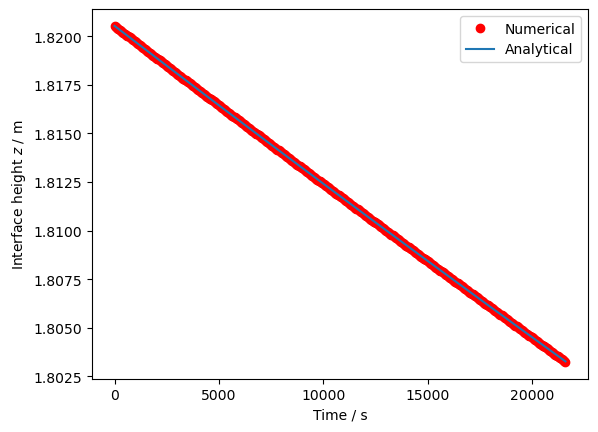

In [21]:
plt.plot(df_evap['Time'], df_evap.z, 'ro', label='Numerical')
plt.plot(df_evap['Time'], z_an, label='Analytical')
plt.xlabel('Time / s')
plt.ylabel('Interface height $z$ / m')
plt.legend()
plt.show()


Simpler checks: check that the final volume is equal to the integrated heat flow over time divided by the latent heat of vaporisation

In [22]:
Q_int_t = np.trapz(df_evap['Q_L'], df_evap['Time'])
V_evap = Q_int_t / (small_tank1.cryogen.h_V - small_tank1.cryogen.h_L) / small_tank1.cryogen.rho_L
V_evap_mod = df_evap['V_L'].iloc[0] - df_evap['V_L'].iloc[-1]
print("V_evap, integrated energy balance = %.3e m^3" % V_evap)
print("V_evap, model  = %.3e m^3" % V_evap_mod)

V_evap, integrated energy balance = 2.893e-02 m^3
V_evap, model  = 2.893e-02 m^3


#### References



Hasan, M., Lin, C. and Van Dresar, N. (1991). Self-Pressurization of a Flightweight Liquid Hydrogen Storage Tank Subjected to Low Heat Flux. [online] Available at: https://ntrs.nasa.gov/api/citations/19910011011/downloads/19910011011.pdf [Accessed 2 Jul. 2024].

Wang, Z. and Mérida, W. (2024). Thermal performance of cylindrical and spherical liquid hydrogen tanks. International Journal of Hydrogen Energy, 53, pp.667–683. doi:https://doi.org/10.1016/j.ijhydene.2023.11.287.